In [41]:
import sys
sys.path.append('/workspaces/bha2/src')

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import random


In [44]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [45]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    os.mkdir(os.path.join(project_path, "tmp"))
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [46]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [47]:
lvlmin = 10
lvlmax = 100
crossmod_gammas = np.empty((lvlmax - lvlmin, 1))
mod_sc_gammas = np.empty((lvlmax - lvlmin, 1))
mod_fc_gammas = np.empty((lvlmax - lvlmin, 1))
sim_gammas = np.empty((lvlmax - lvlmin, 1))

for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_full_g_" + str(round(g, 2)) + ".json")).read())
    crossmod = []
    mod_sc = []
    mod_fc = []
    sim_lvl = []
    for l in range(lvlmin,lvlmax):
        level, labels = level_from_tree(tree, l)
        T = T_from_level(level)
        sim = np.nanmean(similarity_level(fcm_nonzero, scm_nonzero, level))
        mod_sc_lvl = modularity(scm_nonzero, T)
        mod_fc_lvl = modularity(fcm_nonzero, T)
        mod_sc.append(mod_sc_lvl)
        mod_fc.append(mod_fc_lvl)
        sim_lvl.append(sim)
        c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
        crossmod.append(c)
    crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
    mod_sc_gammas = np.hstack((mod_sc_gammas, np.array(mod_sc).reshape(-1,1)))
    mod_fc_gammas = np.hstack((mod_fc_gammas, np.array(mod_fc).reshape(-1,1)))
    sim_gammas = np.hstack((sim_gammas, np.array(sim_lvl).reshape(-1,1)))

In [48]:
xmod = crossmod_gammas[:,1:]
x,y = np.where(xmod == np.nanmax(xmod))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(10, 60)
opt_gamma = round(gammas_vec[y][0],2)
opt_level = levels_vec[x][0]
key_pattern = "gamma_" + str(opt_gamma) + "_lvl_" + str(opt_level)
key_pattern

'gamma_0.8_lvl_47'

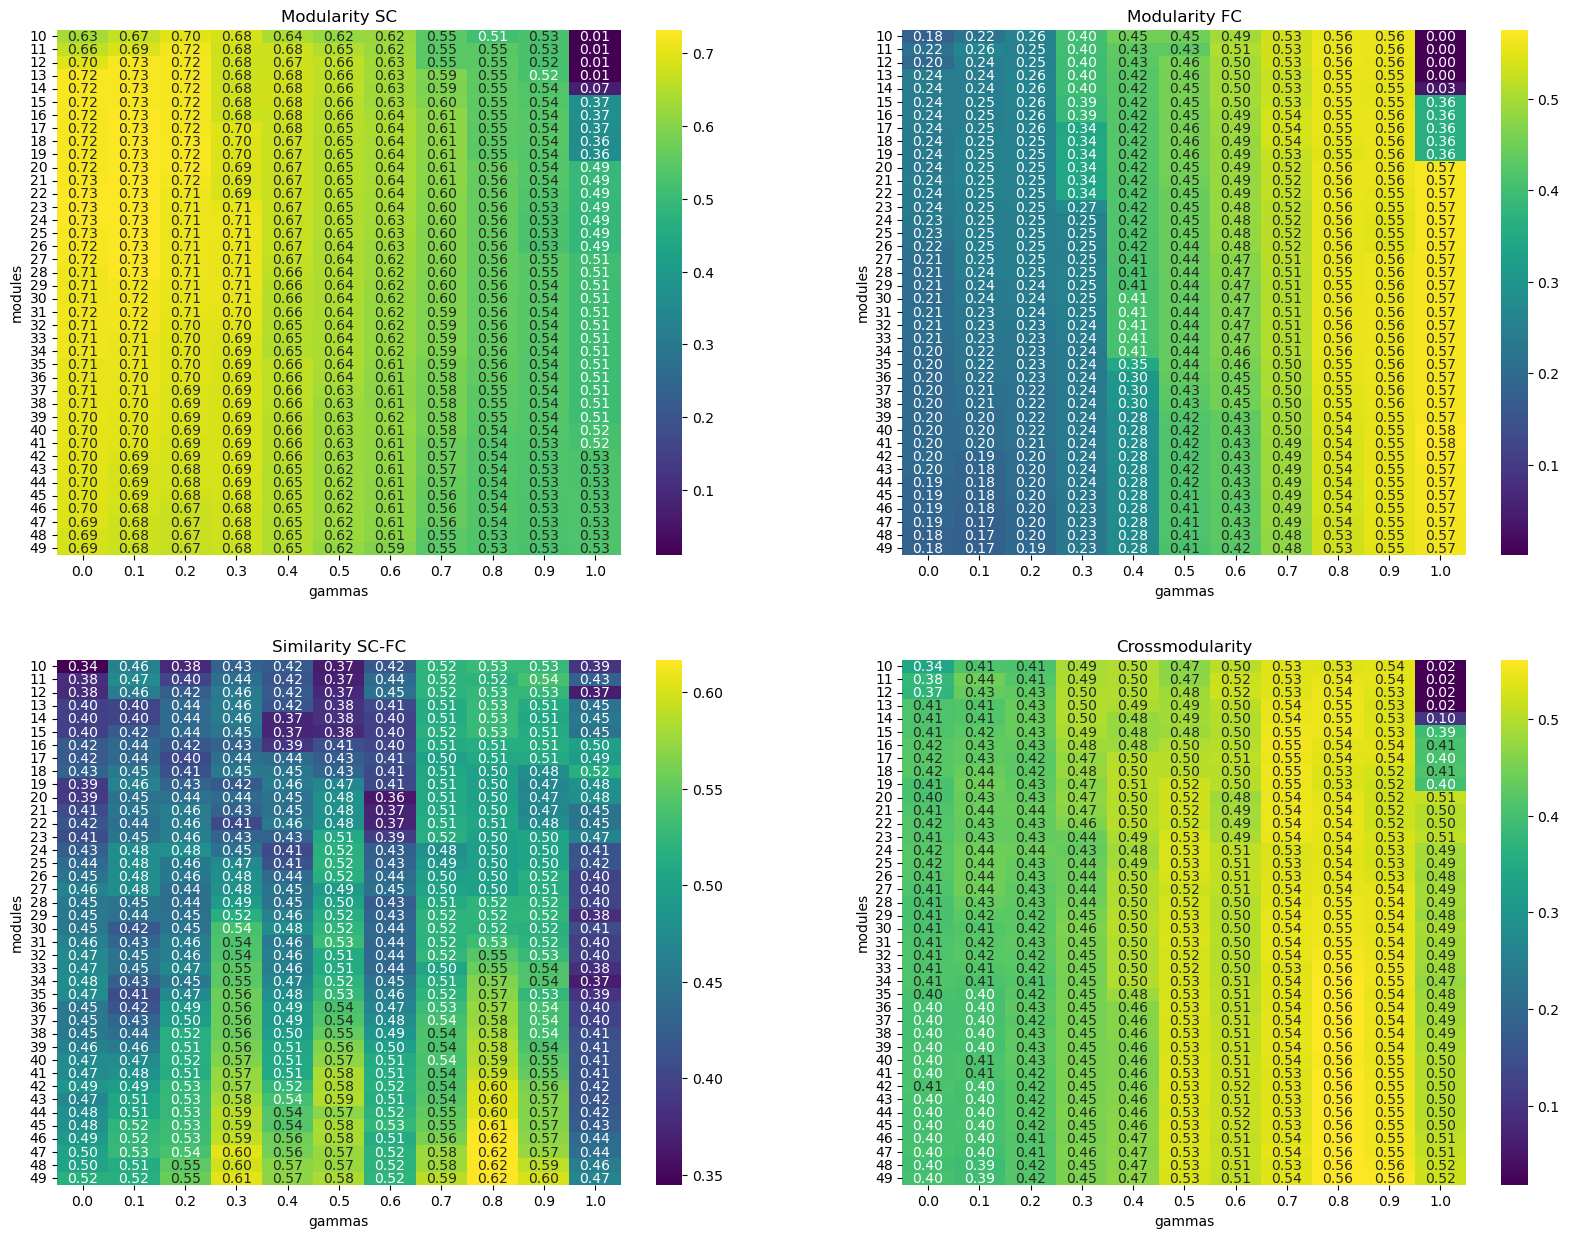

In [49]:
plot, axes = plt.subplots(2, 2, figsize=(20, 15))

h1 = sns.heatmap(mod_sc_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[0,0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("Modularity SC")

h2 = sns.heatmap(mod_fc_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[0,1])
_ = h2.set(xlabel='gammas', ylabel='modules')
_ = h2.set_title("Modularity FC")

h3 = sns.heatmap(sim_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[1,0])
_ = h3.set(xlabel='gammas', ylabel='modules')
_ = h3.set_title("Similarity SC-FC")

h4 = sns.heatmap(crossmod_gammas[:40,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, 50), 
    annot=True, fmt=".2f", ax=axes[1,1])
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

In [109]:
tree = json.loads(open(os.path.join(project_path, "data", "results", "n" + str(conn_size),
        "tree_equaldensity_bin_full_g_" + str(opt_gamma) + ".json")).read())
lvl = opt_level
level, labels = level_from_tree(tree, lvl)
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()

atlas_nonzero = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],1))
print(atlas_nonzero.shape)
old_rois = np.arange(1, atlas_vol.max()+1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)

for idx, rois in enumerate(old_rois):
    atlas_nonzero[atlas_vol == rois] = idx+1

atlas_nonzero_img = nib.Nifti1Image(atlas_nonzero, affine=atlas.affine)
atlas_moduled3D = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2]))
atlas_moduled4D = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],len(level)))
idx = 0
roi_size = []
for rois in level:
    if len(rois) > 1:
        roi_size.append(len(rois))
        mod = get_module_vol(atlas_nonzero_img, rois, idx+1)
        atlas_moduled3D = atlas_moduled3D + mod.astype(int)
        atlas_moduled4D[:,:,:,idx] = get_module_vol(atlas_nonzero_img, rois)
        idx += 1
atlas_moduled4D = atlas_moduled4D[:,:,:,0:idx]
img3D = nib.Nifti1Image(atlas_moduled3D, affine=atlas.affine)
nib.save(img3D, os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition.nii.gz"))
img4D = nib.Nifti1Image(atlas_moduled4D, affine=atlas.affine)
nib.save(img4D, os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition_4D.nii.gz"))

(91, 109, 91, 1)


In [121]:
img3D = nib.Nifti1Image(atlas_moduled3D, affine=atlas.affine)
nib.save(img3D, os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_partition.nii.gz"))

In [117]:
atlas_moduled3D = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2]))
atlas_moduled4D = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],len(level)))
roi_size = []
for idx, rois in enumerate(level):
    roi_size.append(len(rois))
    mod = get_module_vol(atlas_nonzero_img, rois, idx+1)
    atlas_moduled3D = atlas_moduled3D + mod.astype(int)
    atlas_moduled4D[:,:,:,idx] = get_module_vol(atlas_nonzero_img, rois)


cnr_vol = nib.load(os.path.join(project_path, "data", "raw",  "CNR_mean.nii.gz")).get_fdata()
tsnr_vol = nib.load(os.path.join(project_path, "data", "raw",  "tSNR_mean.nii.gz")).get_fdata()
cnr_vec = []
tsnr_vec = []
for roi_vol in range(atlas_moduled4D.shape[3]):
    cnr_vec.append(np.mean(cnr_vol[atlas_moduled4D[:,:,:,roi_vol] == 1]))
    tsnr_vec.append(np.mean(tsnr_vol[atlas_moduled4D[:,:,:,roi_vol] == 1]))



Text(0.5, 1.0, 'tSNR vs ROI size')

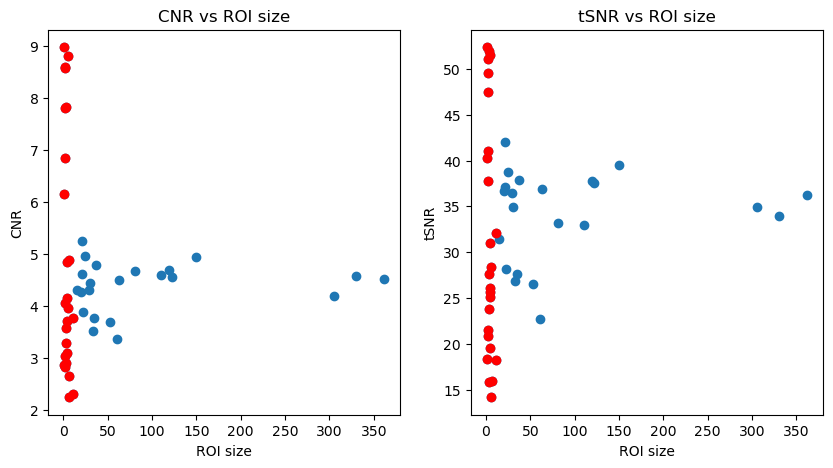

In [119]:
plot, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(roi_size, cnr_vec)
axes[0].scatter(np.array(roi_size)[np.array(roi_size)<=11], np.array(cnr_vec)[np.array(roi_size)<=11], color='r')
axes[0].set_xlabel("ROI size")
axes[0].set_ylabel("CNR")
axes[0].set_title("CNR vs ROI size")
axes[1].scatter(roi_size, tsnr_vec)
axes[1].scatter(np.array(roi_size)[np.array(roi_size)<=11], np.array(tsnr_vec)[np.array(roi_size)<=11], color='r')
axes[1].set_xlabel("ROI size")
axes[1].set_ylabel("tSNR")
axes[1].set_title("tSNR vs ROI size")

In [133]:

#get the indices of rois with roi_size <= 10, cnr > 3.5 and cnr < 6
idx = np.where((np.array(roi_size)<=10) & (np.array(cnr_vec)>3.5) & (np.array(cnr_vec)<6))
np.array(idx)+1

array([[11, 13, 19, 20, 21, 34, 37]])